In [1]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

In [2]:
r_x = np.linspace(-4.0, 4.0, 1000) # create an evenly spaced set of points between -0.99 and 0.99
r_y = np.zeros(1000)
r_z = np.zeros(1000)
r = [r_x, r_y, r_z]

In [3]:
class Cavity(object):
    def __init__(self, cav_coords, radii, width):
        self.r_list = cav_coords # list of cavity centers. Normally, but not always, nucleus coordinates. 
        self.R_list = radii  # list of cavity radii. Normally, but not always, nucleus radii.
        self.sigma = width  # width of the cavity boundary
   

    def __call__(self,  r):
        """
        r is a list of floats of length 3, can be a numpy array as well
        """
        r_vec = np.array(r)
        C = 1.0
        for i, r_i in enumerate(self.r_list):
            r_vec_i = np.array(r_i)
            s_i = np.linalg.norm(r_vec_i - r_vec) - self.R_list[i]
            O_i = (1.0/2.0)*(1 + erf(s_i/self.sigma))
            C_i = 1 - O_i
            C *= 1 - C_i
        C = 1.0 - C
        return C

    
class lin_permittivity():
    def __init__(self, cavity, e_0=1.0, e_inf=2.0):
        
        self.C = cavity
        self.eps_0 = e_0 # permittivity of free space
        self.eps_inf = e_inf # permittivity of solvent
    
    
    def __call__(self, r):
        C_eval = self.C(r)
        permittivity = C_eval*(self.eps_0 - self.eps_inf) + self.eps_inf
    
        return permittivity


class exp_permittivity():
    def __init__(self, cavity, e_0=1.0, e_inf=2.0):
        
        self.C = cavity
        self.eps_0 = e_0 # permittivity of free space
        self.eps_inf = e_inf # permittivity of solvent
    
    
    def __call__(self, r):
        C_eval = self.C(r)
        permittivity = self.eps_0*np.exp((np.log((self.eps_inf/self.eps_0)))*(1.0 - C_eval))
    
        return permittivity

In [4]:
# Analytic nuclear potential
def f_nuc(r):
    R = np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])
    return -1.0 / R

# Analytic guess for solution
def f_phi(r):
    
    R = np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])
    return np.exp(-R*R)

In [5]:
# Global parameters
k = 7                        # Polynomial order
L = [-20,20]                 # Simulation box size
epsilon = 1.0e-6             # Relative precision

# Define MRA and multiwavelet projector
MRA = vp.MultiResolutionAnalysis(order=k, box=L)
P_eps = vp.ScalingProjector(mra=MRA, prec=epsilon)
D_abgv = vp.ABGVDerivative(mra=MRA, a=0.0, b=0.0)
Poissop = vp.PoissonOperator(mra=MRA, prec=epsilon)

In [6]:
# Project analytic nuclear potential
V_nuc = P_eps(f_nuc)

# Initial guess for energy and orbital
E_n = -0.5
phi_n = P_eps(f_phi)
phi_n.normalize()
phi_n *= -1.0

In [7]:
alpha = 10000
beta = (alpha / np.pi)**(3.0/2.0)
nuc_dens = P_eps(vp.GaussFunc(coef=beta, exp=alpha))

In [8]:
rho = nuc_dens + phi_n**2

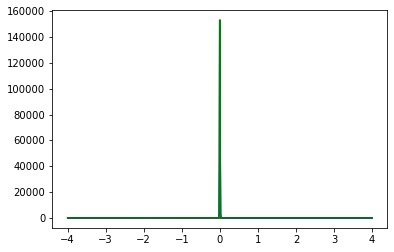

In [9]:
rho_eval = [rho([x, 0.0, 0.0]) for x in r_x]
phi_eval = [phi_n([x, 0.0, 0.0]) for x in r_x]
nuc_dens_eval = [nuc_dens([x, 0.0, 0.0]) for x in r_x]
plt.plot(r_x, phi_eval, "r")
plt.plot(r_x, nuc_dens_eval, "b")
plt.plot(r_x, rho_eval, "g")
plt.show()

In [10]:
coords = [[0.0, 0.0, 0.0]] #centered in 
radii = [2.0598013276]  
width = 0.2

C = Cavity(coords, radii, width)
lin_perm = lin_permittivity(C)
exp_perm = exp_permittivity(C)

lin_perm_tree = P_eps(lin_perm)
exp_perm_tree = P_eps(exp_perm)

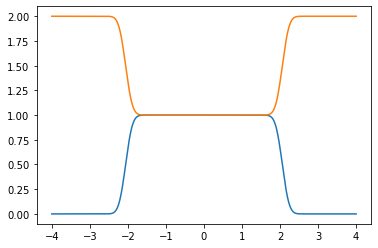

In [11]:
C_eval = [C([x, 0.0, 0.0]) for x in r_x]
eps_eval = [lin_perm([x, 0.0, 0.0]) for x in r_x]
plt.plot(r_x, C_eval)
plt.plot(r_x, eps_eval)
plt.show()

In [12]:
U_vac = Poissop(rho)

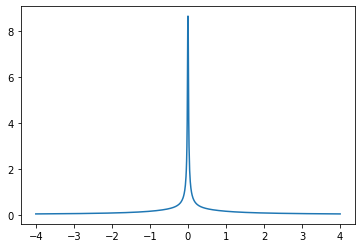

In [13]:
U_vac_eval = [U_vac([x, 0.0, 0.0]) for x in r_x]
plt.plot(r_x, U_vac_eval)
plt.show()

In [14]:
grad_perm =vp.gradient(oper=D_abgv, inp=lin_perm_tree)
grad_U_vac = vp.gradient(oper=D_abgv, inp=U_vac)

In [15]:
def dot (A, B):
    out_vec = []
    for A_i, B_i in zip(A, B):
        out_vec.append(A_i*B_i)
        A_i.clear()
        B_i.clear()
    out_tree = vp.sum(out_vec)
    
    return out_tree

In [16]:
dot_tree = dot(grad_perm, grad_U_vac)

In [17]:
gamma_n = (1/(4*np.pi))*(lin_perm_tree**(-1.0))*dot_tree # zero-th gamma

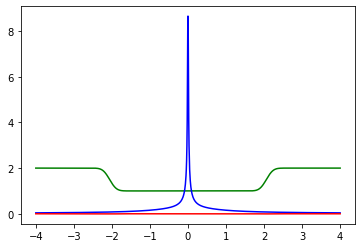

In [20]:
gamma_eval = [gamma_n([x, 0.0, 0.0]) for x in r_x]
plt.plot(r_x, eps_eval, "g")
plt.plot(r_x, U_vac_eval, "b")
plt.plot(r_x, gamma_eval, "r")

In [21]:
rho_eff = rho*(lin_perm_tree**(-1.0))
poiss_tree = rho_eff 
poiss_tree += gamma_n

In [23]:
U_n = Poissop(poiss_tree) #zero-th  total potential

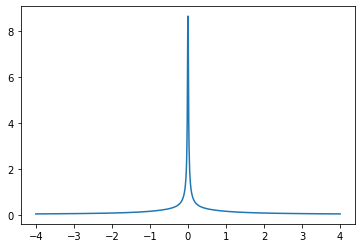

In [24]:
U_n_eval = [U_n([x, 0.0, 0.0]) for x in r_x]
plt.plot(r_x, U_n_eval)
plt.show()

In [25]:
U_r_n = U_n
U_r_n -= U_vac

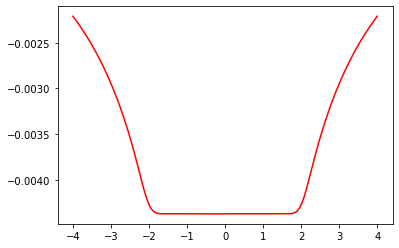

In [26]:
U_r_n_eval = [U_r_n([x, 0.0, 0.0]) for x in r_x]
plt.plot(r_x, U_r_n_eval, "r")
# plt.plot(r_x, U_vac_eval, "b")
# plt.plot(r_x, U_n_eval, "g")
plt.show()

In [27]:
diff = U_r_n.squaredNorm()  # this is U_r_n - U_r_nm1, but since this started as zero we should just not think about it too much
diff

0.022660993911377034

# Dont run the next cell

In [ ]:
# construct new rho and rho_eff
# needs only to be updted outside the loop
rho = nuc_dens + phi_n**2
rho_eff = rho*(lin_perm_tree**(-1.0))

i = 0
update = 1.0e-4 # this should be the orbital update
while((i < 10) and (diff > update)) :   #set a precision threshold

# Dont run the prevoius cell

In [28]:
# construct new gamma from U_n and lin_perm_tree (which is already differentiated)'
grad_U_nm1 = vp.gradient(oper=D_abgv , inp=U_n) # take gradient from previous iteration

In [ ]:
dot_tree = dot(grad_perm, grad_U_nm1)

In [26]:
gamma_n = (1/(4*np.pi))*(lin_perm_tree**(-1.0))*dot_tree

In [27]:
help(vp.FunctionTree)

Help on class FunctionTree in module vampyr._vampyr.vampyr3d:

class FunctionTree(MWTree, RepresentableFunction)
 |  Method resolution order:
 |      FunctionTree
 |      MWTree
 |      RepresentableFunction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(...)
 |      __add__(self: vampyr._vampyr.vampyr3d.FunctionTree, arg0: vampyr._vampyr.vampyr3d.FunctionTree) -> vampyr._vampyr.vampyr3d.FunctionTree
 |  
 |  __call__(...)
 |      __call__(self: vampyr._vampyr.vampyr3d.FunctionTree, arg0: List[float[3]]) -> float
 |  
 |  __iadd__(...)
 |      __iadd__(self: vampyr._vampyr.vampyr3d.FunctionTree, arg0: vampyr._vampyr.vampyr3d.FunctionTree) -> vampyr._vampyr.vampyr3d.FunctionTree
 |  
 |  __imul__(...)
 |      __imul__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __imul__(self: vampyr._vampyr.vampyr3d.FunctionTree, arg0: float) -> vampyr._vampyr.vampyr3d.FunctionTree
 |      
 |      2. __imul__(self:

In [31]:
# make poiss_tree
poiss_tree.clear()

In [32]:
poiss_tree = rho_eff + gamma_n

In [ ]:
# solve poisson equation
U_n = Poissop(poiss_tree)

In [ ]:
# extract reaction potential for convergence check
diff_U_r_n = (U_n - U_vac) - U_r_n
diff = diff_U_r_n.squaredNorm()
print(diff)
U_r_n += diff_U_r_n
    

iteration: 0   Energy: -0.3538784995815114   Norm: 1.0169878647963155   Update: 0.36587448758324526
iteration: 1   Energy: -0.4558627793222508   Norm: 1.274389379298624   Update: 0.3761830430773526
iteration: 2   Energy: -0.49658385257177473   Norm: 1.0741995283703154   Update: 0.08944544671888756
iteration: 3   Energy: -0.4999674305621769   Norm: 1.0065411823526482   Update: 0.008474863789213619
iteration: 4   Energy: -0.5000029718920685   Norm: 1.0007449220333176   Update: 0.0014373456087580158
iteration: 5   Energy: -0.5000046219839581   Norm: 1.0003471833910549   Update: 0.0006592977194035593


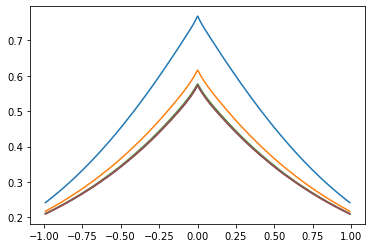

In [4]:
# Minimization loop
thrs = 1.0e-3
update = 1.0
i = 0
while (update > thrs or i > 100):
    # Prepare Helmholtz operator
    mu = np.sqrt(-2*E_n)
    H = vp.HelmholtzOperator(mra=MRA, exp=mu, prec=epsilon)
    
    # Apply Helmholtz operator
    Vphi = V_nuc * phi_n
    phi_np1 = -2*H(Vphi)
    norm = phi_np1.norm()
    
    # Compute orbital and energy updates
    dPhi_n = phi_np1 - phi_n
    dE_n = vp.dot(Vphi, dPhi_n)/phi_np1.squaredNorm()
    update = dPhi_n.norm()
    
    # Prepare for next iteration
    E_n += dE_n
    phi_n += dPhi_n
    phi_n.normalize()
    phi_n.crop(epsilon)
    
    phi_n_plt = [phi_n([x, 0.0, 0.0]) for x in r_x]
    plt.plot(r_x, phi_n_plt)
    
    print("iteration: {}   Energy: {}   Norm: {}   Update: {}".format(i, E_n, norm, update))
    i += 1

plt.show()

In [31]:
H = element()
H